In [19]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import h3
import pandas as pd
import shapely.geometry
import numpy as np
from tobler.util import h3fy
from ipyleaflet import Map, GeoJSON

In [3]:
# 输入文件路径
shapefile_path = "shape/YN.shp"  # ROI Shapefile
tif_path = "tif/CLCD_v01_2023_albert_yunnan.tif"  # 分类图像路径
output_csv = "h3_zonal_stats_local.csv"  # 输出结果文件


<Axes: >

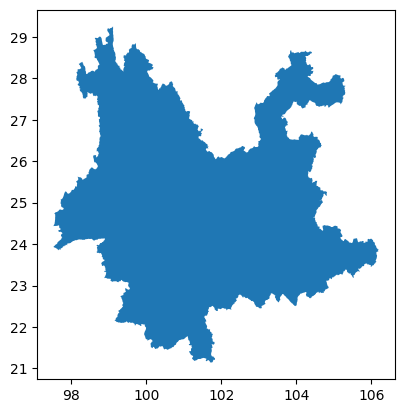

In [13]:
# 加载 Shapefile
gdf = gpd.read_file(shapefile_path)
# 确保 CRS 为 WGS84
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")
# 获取云南边界
gdf.plot()

In [23]:
# 2. 转换为 H3 格网
resolution = 3  # H3 格网分辨率
hexgrid_4 = h3fy(gdf.buffer(0.5), resolution=resolution).reset_index()

# 计算中心点经纬度
hexgrid_4['longitude'] = hexgrid_4['geometry'].apply(lambda x: x.centroid.x)
hexgrid_4['latitude'] = hexgrid_4['geometry'].apply(lambda x: x.centroid.y)

# 过滤感兴趣区域（云南经纬度范围）
hexgrid_4 = hexgrid_4[
    (hexgrid_4['longitude'].between(96, 108)) &
    (hexgrid_4['latitude'].between(20, 30))
][['hex_id', 'geometry']]




C:\Users\ismet\AppData\Local\Temp\ipykernel_19052\2695305364.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hexgrid_4 = h3fy(gdf.buffer(0.5), resolution=resolution).reset_index()


In [24]:
m = Map(center = [23.7, 102.8], zoom = 6 )
geojson = GeoJSON(data=hexgrid_4.__geo_interface__)
m.add_layer(geojson)
m

Map(center=[23.7, 102.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [26]:
zonal_stats_result = []
resolution_10 = 4

with rasterio.open(tif_path) as src:
    print(src.nodata)
    for index, row in hexgrid_4.iterrows():
        hex_id = row['hex_id']
        hex_geom = row['geometry']

         # 使用 h3fy 生成 10 级 H3 格网
        hexgrid_10 = h3fy(gpd.GeoDataFrame({'geometry': [hex_geom]}, crs="EPSG:4326"), resolution=resolution_10).reset_index()
        print(f"Processing Hexgrid 4 with hex_id: {hex_id}, containing {len(hexgrid_10)} hexes")
        for _, h_row in hexgrid_10.iterrows():
            geom = h_row['geometry']
            stats = zonal_stats(
                vectors=[geom],
                raster=src.read(1),  # 分类图像的第一个波段
                affine=src.transform,
                stats="sum",
                categorical=True,
                geojson_out=False
            )
            if stats:
                for class_value, area in stats[0].items():
                    zonal_stats_result.append({
                        'hex_id_3': hex_id,
                        'hex_id_10': h_row['hex_id'],
                        'class': class_value,
                        'area': area
                    })

result_df = pd.DataFrame(zonal_stats_result)
result_df.to_csv(output_csv, index=False)

print(f"分析完成，结果已保存为 {output_csv}")



0.0
Processing Hexgrid 4 with hex_id: 834009fffffffff, containing 7 hexes


OverflowError: Python integer -999 out of bounds for uint8